### Generate the ROC curve, run demo_ROC_ratio.py first to generate FPRs and TPRs for Density Ratio method. 

In [1]:
# %%

import torch 
import matplotlib.pyplot as plt
import numpy as np

def g(t):
    return -(t-1)*t

def dg(t):
    return -2*t+1

def f(x):
    n, d, nt = x.shape
    pairwise_features = torch.zeros((n, d * (d + 1) // 2, nt))
    
    idx = 0
    for i in range(d):
        for j in range(i, d):
            pairwise_features[:, idx, :] = x[:, i, :] * x[:, j, :]
            idx += 1
            
    return pairwise_features

def phi(fXqt, t, sigma = .05):
    Kt = torch.exp(-(t[:, None] - t[:, None].T)**2/sigma**2/2)
    Eqtfx = fXqt[0, :, :] @ Kt / torch.sum(Kt, 1)
    print(Eqtfx.shape)
    return fXqt - Eqtfx

In [2]:
# %%

def train(X, t, lmbd = .001):
    phiXqt = phi(f(X), t).squeeze().transpose(1, 0)
    fXqt = f(X).squeeze().transpose(1, 0)

    n = phiXqt.shape[0]
    d = phiXqt.shape[1]
    
    A = phiXqt.T @ torch.diag(g(t)) @ phiXqt / n
    b = dg(t) @ fXqt / n
    b = b[:, None]
    
    alpha_hat = torch.zeros(d, 1)
    
    def proximal_operator_l1(v, alpha):
        return np.sign(v) * np.maximum(np.abs(v) - alpha, 0)

    def proximal_gradient_descent(Q, c, lambd, x0, lr, max_iter):
        x = x0.copy()
        for _ in range(max_iter):
            gradient = Q @ x + c
            x = x - lr * gradient
            x = proximal_operator_l1(x, lr * lambd)
        return x
    
    sol = proximal_gradient_descent(A.detach().numpy(), 
                                    b.detach().numpy(), 
                                    lmbd, alpha_hat.detach().numpy(), 0.01, 10000)
    return torch.tensor(sol)

generating samples for each time point ..., may take a while...done.


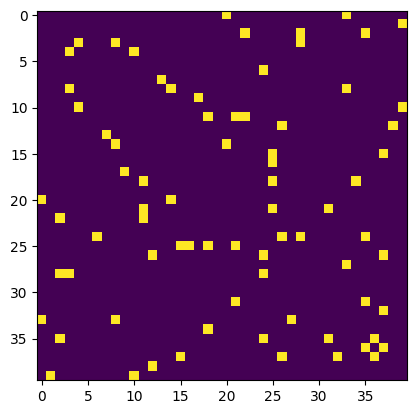

In [3]:
# %%

torch.manual_seed(2)
n = 1
nt = 1000
d = 40

G = torch.rand(d, d) + torch.eye(d) < .023
G = G + G.t()
plt.imshow(G)

Xqt = torch.zeros(n, d, nt)
t = torch.rand(nt)

print("generating samples for each time point ..., may take a while...", end="")
base = torch.randn(d, 2*d)
base = base @ base.T/2/d
for i in range(nt):
    nz = torch.zeros(1, d)
    mu = torch.zeros(1, d) + t[i]*nz
    Theta = torch.eye(d)
    Theta = Theta + base
    Theta.fill_diagonal_(2.0)
    Theta[G == 1] = .45*t[i]
                
    Cov = torch.inverse(Theta)
    Xqt[:, :, i] = torch.distributions.MultivariateNormal(mu, Cov).sample((n,)).squeeze()

print("done.")

In [4]:
# %%

print('training model...')

ROC_points = []

# get 10 values of lambda from 1e-3 to 1e-1
for lmbd in np.logspace(-3, -1, 20):

    alpha_hat = train(Xqt, t, lmbd= lmbd)

    #reconstruct alpha to Theta 
    Theta = torch.zeros(d, d)
    idx = 0
    for i in range(d):
        for j in range(i, d):
            Theta[i, j] = alpha_hat[idx]
            Theta[j, i] = alpha_hat[idx]
            idx += 1

    print(Theta)

    FP = 0
    TP = 0

    for i in range(d):
        for j in range(i+1, d):
            if torch.abs(Theta[i, j]) > 1e-6:
                if G[i, j] == 1:
                    TP += 1
                else:
                    FP += 1
            
        
    NP = torch.sum(G)/2
    NN = d*(d-1)/2 - NP

    FPR = FP / NN   
    TPR = TP / NP

    print([FPR, TPR])
    ROC_points.append(torch.tensor([FPR, TPR]))

ROC_points = torch.stack(ROC_points)

training model...
torch.Size([820, 1000])
tensor([[-0.2912, -0.0881,  0.3432,  ...,  0.3143,  0.3892, -0.6623],
        [-0.0881, -0.5417,  0.5989,  ..., -0.9053,  0.2221, -0.8231],
        [ 0.3432,  0.5989,  0.0000,  ...,  0.6801,  0.1315, -0.5494],
        ...,
        [ 0.3143, -0.9053,  0.6801,  ...,  0.6887, -0.7854,  0.3459],
        [ 0.3892,  0.2221,  0.1315,  ..., -0.7854, -0.1926, -0.2059],
        [-0.6623, -0.8231, -0.5494,  ...,  0.3459, -0.2059,  0.7911]])
[tensor(0.9892), tensor(1.)]
torch.Size([820, 1000])
tensor([[-0.2828, -0.0726,  0.3290,  ...,  0.3071,  0.3735, -0.6415],
        [-0.0726, -0.5265,  0.5853,  ..., -0.8882,  0.2047, -0.8019],
        [ 0.3290,  0.5853,  0.0000,  ...,  0.6704,  0.1162, -0.5382],
        ...,
        [ 0.3071, -0.8882,  0.6704,  ...,  0.6801, -0.7635,  0.3371],
        [ 0.3735,  0.2047,  0.1162,  ..., -0.7635, -0.1781, -0.1965],
        [-0.6415, -0.8019, -0.5382,  ...,  0.3371, -0.1965,  0.7713]])
[tensor(0.9704), tensor(1.)]
torch.Si

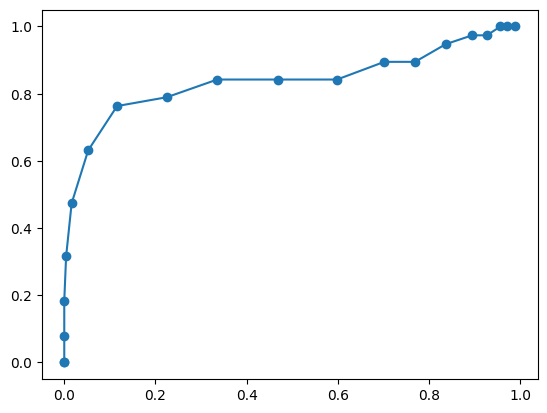

In [5]:
# %%

# plot ROC curve
plt.plot(ROC_points[:, 0], ROC_points[:, 1], marker='o')

torch.save(ROC_points, 'TSM_ROC_points.pt')

Text(0, 0.5, 'True Positive Rate')

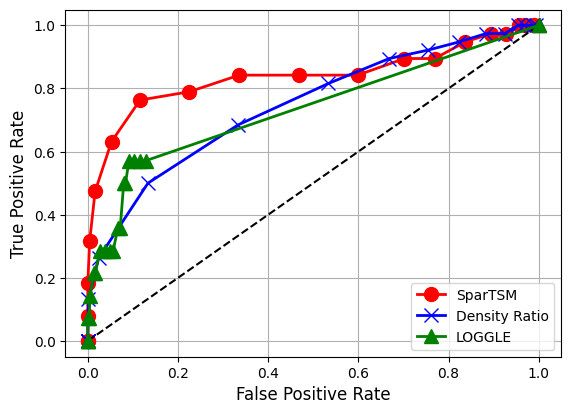

In [6]:
# %%

ROC_points = torch.load('TSM_ROC_points.pt')
ratio_ROC_points = torch.load('ratio_ROC_points.pt')

plt.plot(ROC_points[:, 0], ROC_points[:, 1], marker='o', label='SparTSM', color='r', linewidth=2, markersize=10)
plt.plot(ratio_ROC_points[:, 0], ratio_ROC_points[:, 1], marker='x', label='Density Ratio', color='b', linewidth=2, markersize=10)

# plot the diagonal line
plt.plot([0, 1], [0, 1], marker='^', linestyle='--', color='k', markersize=10)

# logg tpr and fpr, see loggle/README.md

TPR = [1.0, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5, 0.5, 0.35714285714285715, 0.35714285714285715, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.21428571428571427, 0.21428571428571427, 0.14285714285714285, 0.07142857142857142, 0.07142857142857142, 0.0, 0.0]
FPR = [1.0, 0.12924281984334204, 0.11488250652741515, 0.10182767624020887, 0.09138381201044386, 0.0835509138381201, 0.07963446475195822, 0.07180156657963446, 0.06657963446475196, 0.05613577023498695, 0.04960835509138381, 0.037859007832898174, 0.02741514360313316, 0.015665796344647518, 0.013054830287206266, 0.005221932114882507, 0.0026109660574412533, 0.0, 0.0, 0.0]

plt.plot(FPR, TPR, marker='^', label='LOGGLE', color='g', linewidth=2, markersize=10)
plt.legend(fontsize=10)
plt.grid()

# aspect ratio to 16:9
plt.gca().set_aspect(.7, adjustable='box')

# make font big
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)